# Augmentation

In [1]:
import tensorflow as tf
import h5py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

In [2]:
#Read performance eval result and model metadata
performance_bpnet = pd.read_csv('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/model_evaluations/augmentation_48.csv')
performance_basenji = pd.read_csv('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/model_evaluations/augmentation_basenji.csv')

performance_whole = pd.concat([performance_bpnet, performance_basenji])

In [3]:
augm_dict = {('False', False): 'None', 
                 ('r_crop', False): 'Shift', 
                 ('False', True): 'RC', 
                 ('r_crop', True): 'Shift + RC'}


# model_name = 'bpnet'
bin_size=128
title_str = 'Bin size = {}'.format(bin_size)
whole_raw_performance = performance_whole[(performance_whole['pred type']=='raw')
                                          &(performance_whole['eval type']=='whole')
                                         &(performance_whole['bin_size']==bin_size)
                                         ]
descriptions = whole_raw_performance.iloc[:,7:]
avg_perf = whole_raw_performance.groupby('run_dir').mean().reset_index()
avg_perf_complete = avg_perf.merge(descriptions, how='left', left_on='run_dir',right_on='run_dir').drop_duplicates(subset='run_dir')


avg_perf_complete['dataset'] = ['peak centered' if 'peak' in d else 'random chop' for d in avg_perf_complete['data_dir']]
avg_perf_complete['augmentation type'] = [augm_dict[(c,r)] for (c,r) in zip(avg_perf_complete['crop'], avg_perf_complete['rev_comp_x'])]
avg_perf_complete = avg_perf_complete.sort_values('augmentation type')


In [4]:
model_name_dict = {'basenjimod':'basenji', 'basenji_w1_b64':'basenji'}
avg_perf_complete['model'] = [model_name_dict.get(m,m)+'\n'+avg_perf_complete['dataset'].values[i] for i,m in enumerate(avg_perf_complete['model_fn'].values)]


## Augmentaion vs. Performance

Text(0, 0.5, "Pearson's R (whole)")

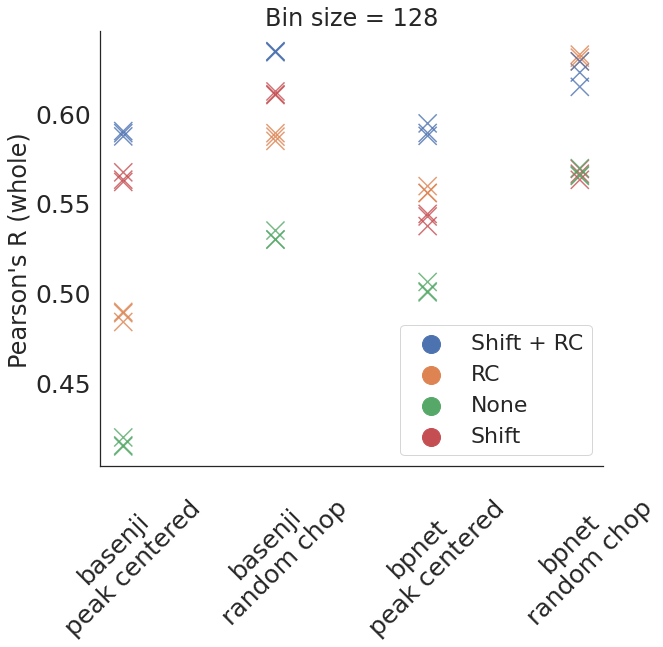

In [21]:
sns.set(font_scale = 2,style='white')
fig = plt.figure(figsize = (9,8))

ax = sns.scatterplot(data=avg_perf_complete.sort_values('model'), x='model', y='pr_corr', 
               hue='augmentation type', s=330, alpha=0.8, marker='x')
sns.despine()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:],loc = 'lower right',markerscale=3)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set(xlabel=None)
plt.xticks(rotation=45);
plt.title(title_str);
plt.ylabel('Pearson\'s R (whole)')

## Augmentation vs. Robustness

In [6]:
all_robustness_scores = []
for one_run_dir in avg_perf_complete['run_dir'].values:
    res_path = glob.glob('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/robustness_test/*/*_{}/variance_of_preds.h5'.format(os.path.basename(one_run_dir)))
    assert len(res_path) == 1, 'Too many results!'
    robustness_result_path = res_path[0]
    h5_dataset = h5py.File(robustness_result_path, 'r')
    all_robustness_scores.append((h5_dataset['prediction_variance'][:]).mean())
    h5_dataset.close()
    
avg_perf_complete['robustness score'] = all_robustness_scores
avg_perf_complete = avg_perf_complete.sort_values('model')

Text(0, 0.5, 'Variation')

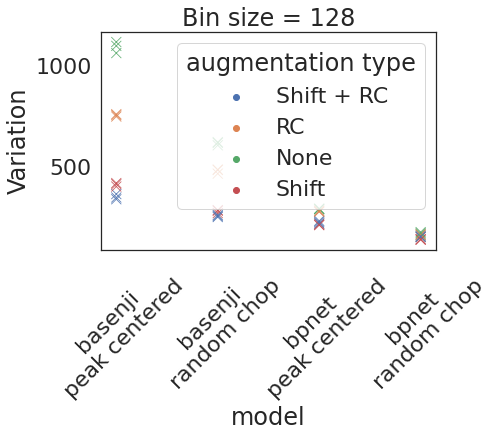

In [7]:
sns.scatterplot(data=avg_perf_complete.sort_values('model'), x='model', y='robustness score', 
               hue='augmentation type', s=100, alpha=0.9, marker='x')

plt.xticks(rotation=45);
plt.title(title_str);
plt.ylabel('Variation')

## Robustness vs. Performance

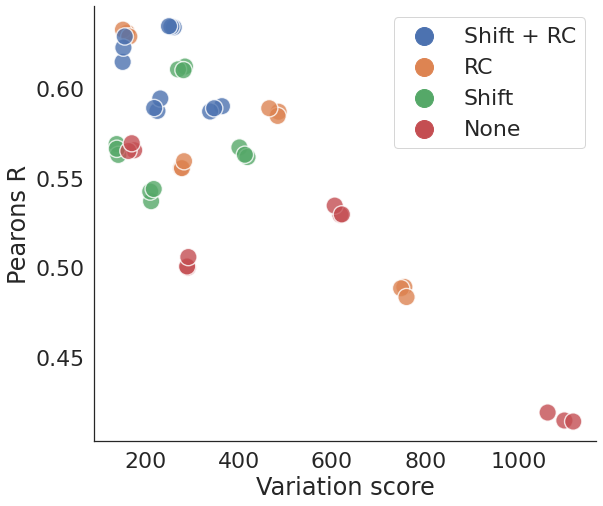

In [8]:
sns.set(font_scale = 2,style='white')
fig = plt.figure(figsize = (9,8))

ax = sns.scatterplot(data = avg_perf_complete, x = 'robustness score', y= 'pr_corr',
                     hue = 'augmentation type',s= 300,alpha = 0.8)
ax.set_xlabel('Variation score')
ax.set_ylabel('Pearons R');
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:],loc = 'upper right',markerscale=3)
sns.despine()

# Binary Model comparison

In [9]:
import pandas as pd
import seaborn as sns

In [10]:
df = pd.read_csv('/home/amber/QuantPred/datasets/binary/performance.csv',index_col = 0)

In [11]:
df

,model,chrom_auroc,chrome aupr,chr pearson r,peak auroc,peak aupr,peak pearson r,model type
0,rb_bi,0.856852,0.396624,0.404047,0.871567,0.692850,0.621246,Binary
1,basset_bi,0.780297,0.314453,0.380003,0.791483,0.585901,0.543745,Binary
2,rb_cov,0.879952,0.374688,0.551990,0.861478,0.663903,0.680437,Binary
3,basset_cov,0.733517,0.217261,0.378554,0.710897,0.498852,0.500808,Binary
4,bpnet_base,0.914321,0.506876,0.673858,0.838377,0.659631,0.662583,Quantiative
5,basenji_128,0.912492,0.488942,0.668200,0.836745,0.650373,0.653664,Quantiative
6,basenji_2k,0.895184,0.460035,0.656958,0.813998,0.627498,0.642830,Quantiative
7,rb_32,0.931332,0.561275,0.704188,0.868770,0.707412,0.698668,Quantiative
8,rb_base,0.920390,0.539550,0.696068,0.850259,0.683123,0.686464,Quantiative


/home/amber/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


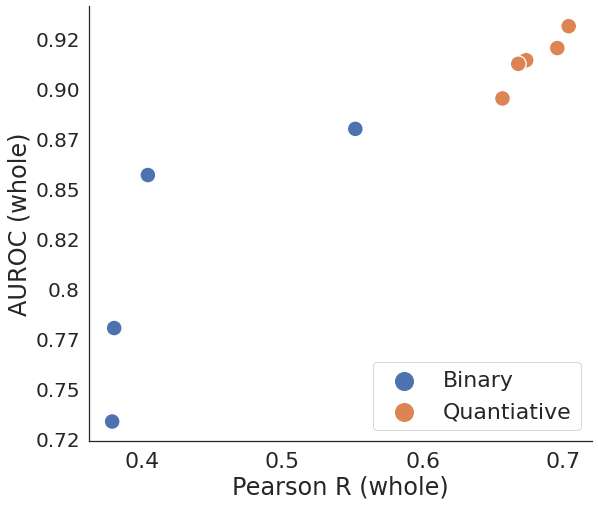

In [17]:
sns.set(font_scale = 2,style='white')
fig = plt.figure(figsize = (9,8));

ax = sns.scatterplot(data = df, x = 'chr pearson r', y = 'chrom_auroc',hue = 'model type',
                    s= 250);
#ax.set_title('performance on whole chromosome test set')
ax.set_xlabel('Pearson R (whole)')
ax.set_ylabel('AUROC (whole)');
ax.set_yticklabels(ax.get_yticks().astype('U4'), size = 20)
ax.legend(loc = 'lower right',markerscale=3)
sns.despine()

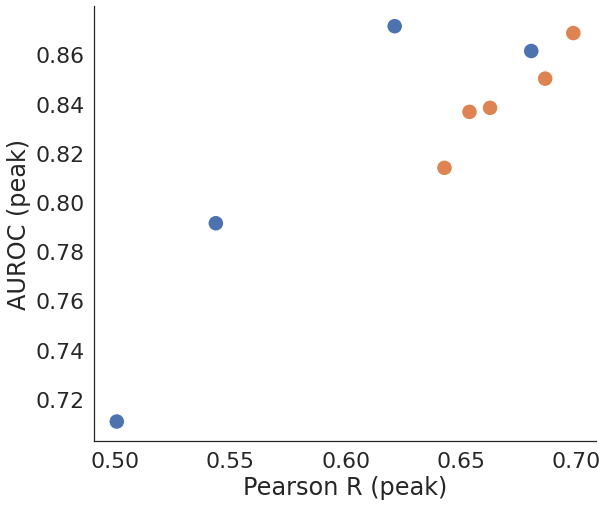

In [13]:
sns.set(font_scale = 2,style='white')
fig = plt.figure(figsize = (9,8))

ax = sns.scatterplot(data = df, x = 'peak pearson r', y = 'peak auroc',hue = 'model type',
                    s = 250)
#ax.set_title('performance on peak centered test set')
ax.set_xlabel('Pearson R (peak)')
ax.set_ylabel('AUROC (peak)');
legend = ax.legend()
legend.remove()
sns.despine()

# VCF analysis

In [23]:
import h5py
import pandas as pd
import custom_fit
import numpy as np
import modelzoo
import explain
import tensorflow as tf
from tensorflow import keras
import glob
import h5py
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy
augm_dict = {('False', False): 'None', 
                 ('r_crop', False): 'Shift', 
                 ('False', True): 'RC', 
                 ('r_crop', True): 'Shift + RC'}

cagi_meta = '/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shush/CAGI5/final_cagi_metadata.csv'
eval_dir= '/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/model_evaluations/'

In [24]:
def compile_cagi_result(h5_dir,cagi_metadata):
    cagi_df = pd.read_csv(cagi_metadata)
    df_dict = {}
    for tf in cagi_df['8'].unique():
        df_dict[tf] = []
              
    VCFList = glob.glob(h5_dir)
    
    model = []
    average = []
    for vcf_result in VCFList:        
        f =  h5py.File(vcf_result, "r")
        total_diff = f['vcf_diff'][()]
        average_diff = np.mean(total_diff,axis = 1)
        f.close()

        #Pearson R evaluation
        temp_r = 0
        for tf in cagi_df['8'].unique():
            mask = (cagi_df['8'] == tf)
            cagi_diff = cagi_df[mask]['6']
            vcf_diff = average_diff[mask]
            vcf_diff = np.nan_to_num(vcf_diff)
            tf_r = stats.pearsonr(cagi_diff,vcf_diff)
            df_dict[tf].append(tf_r[0])
            temp_r += tf_r[0]

        average.append(temp_r/len(df_dict.keys()))

        file_name = vcf_result.split('/')[-1]
        run_name = file_name.split('.')[0]
        run_name = run_name.split('-')[-1]
        model.append(run_name)
    
    
    df_dict['model'] = model
    df_dict['Average'] = average
    
    vcf_df =pd.DataFrame.from_dict(df_dict)
    cols = vcf_df.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    vcf_df = vcf_df[cols]
    vcf_df = vcf_df.set_index('model')
    return vcf_df

## VCF visualization heatmap + profile

In [25]:
%%time
vcf_data = '/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shush/CAGI5/CAGI_onehot.h5'
f =  h5py.File(vcf_data, "r")
alt_3k = f['alt'][()]
ref_3k = f['ref'][()]
f.close()

CPU times: user 0 ns, sys: 394 ms, total: 394 ms
Wall time: 390 ms


In [26]:
alt,ref = custom_fit.center_crop(alt_3k,ref_3k,2048)

In [27]:
cagi_df = pd.read_csv(cagi_meta,
                      index_col=0).reset_index()

In [28]:
model = modelzoo.load_model('./paper_runs/new_models/32_res/run-20211023_095136-to28llil',compile = True)

/home/amber/QuantPred/modelzoo.py:879: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(config_file)


In [29]:
vcf_result = '/home/amber/QuantPred/datasets/VCF/CAGI_results/new_model/run-20211023_095136-to28llil.h5'
f =  h5py.File(vcf_result, "r")
total_diff = f['vcf_diff']
average_diff = np.mean(total_diff,axis = 1)
f.close()

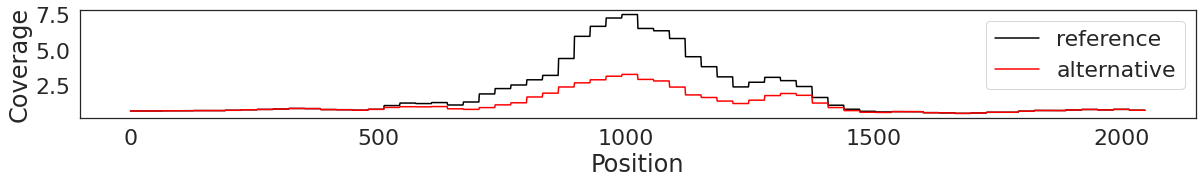

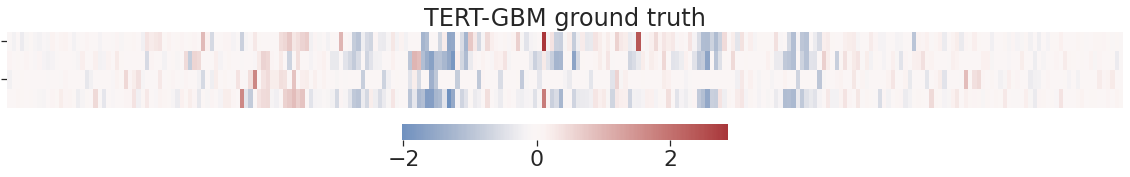

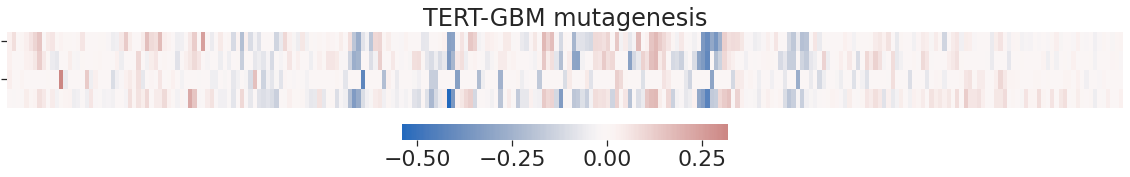

In [45]:
#visualize the largest diff per cell line
#and the heat map for saturated in silico mutagenesis
import importlib
importlib.reload(explain)
max_idx = explain.visualize_vcf(ref,alt,model,average_diff,cagi_df)

In [15]:
cagi_df[cagi_df['8'] == 'TERT-GBM']

,index,0,1,2,3,4,5,6,7,8,9
562,562,chr5,1293584,1296656,G,A,+,-0.06,0.01,TERT-GBM,challenge
563,563,chr5,1293584,1296656,G,C,+,-0.13,0.01,TERT-GBM,challenge
564,564,chr5,1293584,1296656,G,T,+,-0.28,0.11,TERT-GBM,challenge
565,565,chr5,1293585,1296657,G,A,+,-0.03,0.01,TERT-GBM,challenge
566,566,chr5,1293585,1296657,G,C,+,0.18,0.03,TERT-GBM,challenge
...,...,...,...,...,...,...,...,...,...,...,...
12710,12725,chr5,1293825,1296897,G,C,+,-0.29,0.02,TERT-GBM,release
12711,12726,chr5,1293825,1296897,G,T,+,0.11,0.01,TERT-GBM,release
12712,12727,chr5,1293826,1296898,G,A,+,-0.07,0.03,TERT-GBM,release
12713,12728,chr5,1293826,1296898,G,C,+,-0.08,0.00,TERT-GBM,release


In [18]:
cagi_df.iloc[774]

index          774
0             chr5
1          1293670
2          1296742
3                G
4                T
5                +
6            -2.02
7                1
8         TERT-GBM
9        challenge
Name: 774, dtype: object

In [16]:
max_idx

[5826,
 260,
 774,
 2108,
 2190,
 16015,
 5028,
 13286,
 6516,
 7455,
 17358,
 10545,
 14891,
 13763,
 14659]

## CAGI Perfomance

Result ready and plotted in heat map
Can be converted to scatter plot if needed

In [46]:
csv_list = os.listdir(eval_dir)
metadata = []
for csv_f in csv_list:
    if 'SCALES' not in csv_f and 'replicates' not in csv_f:
        metadata.append(pd.read_csv(eval_dir +csv_f))
metadata = pd.concat(metadata)

<AxesSubplot:ylabel='model'>

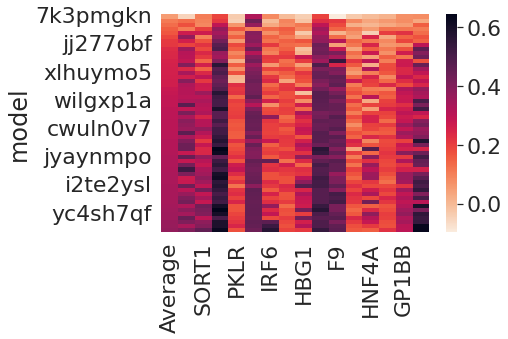

In [47]:
#compile all cagi result together
# sns.set(rc = {'figure.figsize':(15,8)})
all_result = compile_cagi_result('/home/amber/QuantPred/datasets/VCF/CAGI_results/*/*.h5',cagi_meta)
all_vcf_df = all_result.sort_values(['Average'])
sns.heatmap(all_vcf_df,cmap = sns.cm.rocket_r)


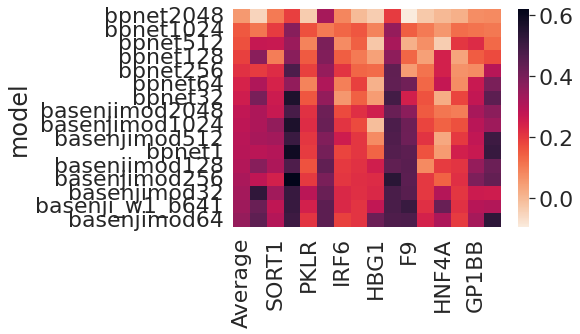

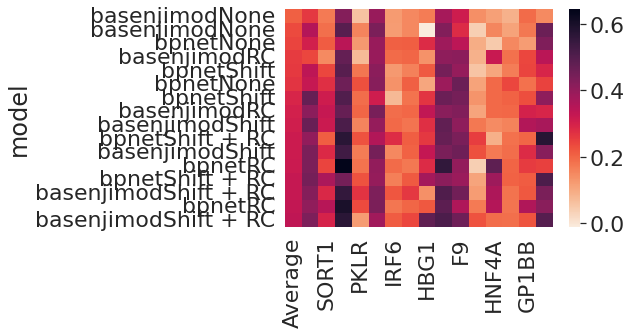

In [48]:
# across bin expeirment
bin_result = compile_cagi_result('/home/amber/QuantPred/datasets/VCF/CAGI_results/bin_size/*.h5',cagi_meta)
bin_vcf_df = bin_result.sort_values(['Average'])
bin_size = []
structure = []
for model in bin_vcf_df.index:
    metadata_entry = metadata[metadata['run_dir'].str.contains(model)]
    bin_size.append(str(metadata_entry['bin_size'].unique()[0]))
    structure.append(metadata_entry['model_fn'].unique()[0])
    
sns.heatmap(bin_vcf_df,cmap = sns.cm.rocket_r,yticklabels=np.char.add(structure, bin_size))
plt.show()
# across augemntation experiment 
aug_result = compile_cagi_result('/home/amber/QuantPred/datasets/VCF/CAGI_results/augmentation/*.h5',cagi_meta)
aug_vcf_df = aug_result.sort_values(['Average'])
aug = []
structure = []
for model in aug_vcf_df.index:
    metadata_entry = metadata[metadata['run_dir'].str.contains(model)]
    structure.append(metadata_entry['model_fn'].unique()[0])
    rev_comp = metadata_entry['rev_comp'].unique()[0]
    shift = metadata_entry['crop'].unique()[0]
    aug.append(augm_dict[(shift,rev_comp)])
    
sns.heatmap(aug_vcf_df,cmap = sns.cm.rocket_r,yticklabels=np.char.add(structure, aug))
plt.show()


## Robust VCF performance influence

In [49]:
cagi_df = pd.read_csv(cagi_meta)
diff_score = cagi_df['6']
csv_list = os.listdir(eval_dir)
metadata = []
for csv_f in csv_list:
    if 'SCALES' not in csv_f and 'replicates' not in csv_f:
        metadata.append(pd.read_csv(eval_dir +csv_f))
metadata = pd.concat(metadata)

In [50]:
df_dict = {}
for tf in cagi_df['8'].unique():
    df_dict[tf] = []
    df_dict[tf+'_n'] = []

In [51]:
VCFList = glob.glob('/home/amber/QuantPred/datasets/VCF/CAGI_no_robust/*/*.h5')

robust_average = []
no_robust_average = []
model = []
exp = []
for no_robust_result in VCFList:
    file_name = no_robust_result.split('/')[-2:]
    robust_result = os.path.join('/home/amber/QuantPred/datasets/VCF/CAGI_results',file_name[0],file_name[1])
    exp.append(file_name[0])
    
    #read robust result
    f =  h5py.File(robust_result, "r")
    total_diff = f['vcf_diff'][()]
    average_diff = np.mean(total_diff,axis = 1)
    f.close()
    
    temp_r = 0
    for tf in cagi_df['8'].unique():
        mask = (cagi_df['8'] == tf)
        cagi_diff = cagi_df[mask]['6']
        vcf_diff = average_diff[mask]
        vcf_diff = np.nan_to_num(vcf_diff)
        tf_r = scipy.stats.pearsonr(cagi_diff,vcf_diff)
        df_dict[tf].append(tf_r[0])
        temp_r += tf_r[0]
        
    robust_average.append(temp_r/15)
    
    #read no robust result
    f =  h5py.File(no_robust_result, "r")
    total_diff = f['vcf_diff'][()]
    average_diff = np.mean(total_diff,axis = 1)
    f.close()
    
    temp_r = 0
    for tf in cagi_df['8'].unique():
        mask = (cagi_df['8'] == tf)
        cagi_diff = cagi_df[mask]['6']
        vcf_diff = average_diff[mask]
        vcf_diff = np.nan_to_num(vcf_diff)
        tf_r = scipy.stats.pearsonr(cagi_diff,vcf_diff)
        df_dict[tf+'_n'].append(tf_r[0])
        temp_r += tf_r[0]
        
    no_robust_average.append(temp_r/15)

    #fill df
    file_name = robust_result.split('/')[-1]
    model.append(file_name)
   
    
df_dict['model'] = model
df_dict['average'] = robust_average
df_dict['no robust average'] = no_robust_average
df_dict['experiment'] = exp 

In [52]:
vcf_robust = pd.DataFrame.from_dict(df_dict)
vcf_robust_average = vcf_robust[['model','average','no robust average','experiment']].copy()

In [53]:
structure = []
for model in vcf_robust_average['model']:
    model = model.split('.')[0]
    metadata_entry = metadata[metadata['run_dir'].str.contains(model)]
    if len(metadata_entry)!=0:
        structure.append(metadata_entry['model_fn'].unique()[0])
    else:
        structure.append('binary')

vcf_robust_average['model_fn'] = structure
vcf_robust_average['diff'] = vcf_robust_average['average'] - vcf_robust_average['no robust average']

In [54]:
order=vcf_robust_average.sort_values(['model_fn','experiment'])['model']

/home/amber/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


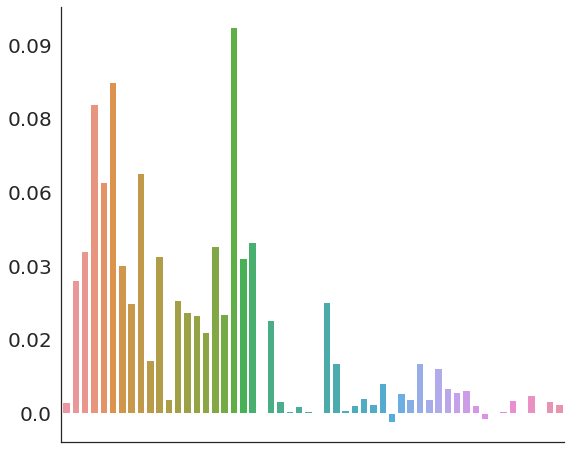

In [75]:
sns.set(font_scale = 2,style='white')
fig = plt.figure(figsize = (9,8))

fig = sns.barplot(data = vcf_robust_average, x= 'model', y = 'diff',order = order)
fig.set(xlabel='', ylabel='')
fig.set_yticklabels(fig.get_yticks().astype('U4'), size = 20)
fig.set(xticklabels=[]);
sns.despine()

In [77]:
import yaml
shift_aug = []
for index,entry in vcf_robust_average.iterrows():
    model = entry['model']
    if entry['model_fn'] == 'binary':
        shift_aug.append(False)
        continue
    config_file =glob.glob('/home/amber/QuantPred/paper_runs/*/*/'+model[:-3]+'/files/config.yaml')[0]
    with open(config_file,'r') as stream:
        data_loaded = yaml.safe_load(stream)
        if 'crop' not in data_loaded.keys():
            shift_aug.append(True)
            continue
        aug = data_loaded['crop']['value']
        if aug == 'r_crop':
            shift_aug.append(True)
        else:
            shift_aug.append(False)



In [78]:
vcf_robust_average['shift augmentation'] = shift_aug

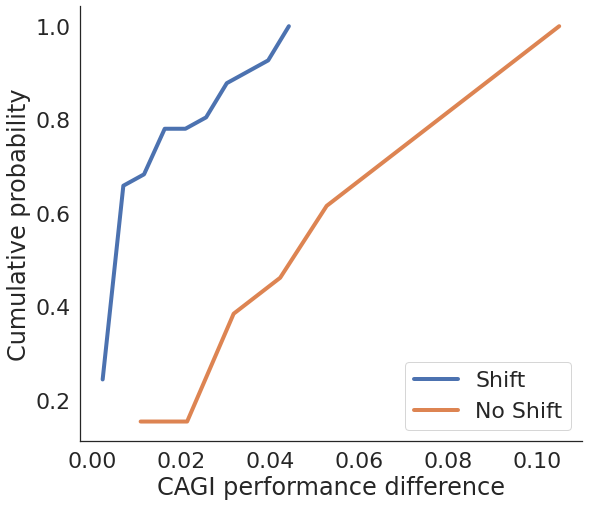

In [90]:
# getting data of the histogram
sns.set(font_scale = 2,style='white')
fig = plt.figure(figsize = (9,8))

count, bins_count = np.histogram(vcf_robust_average[vcf_robust_average['shift augmentation']==True]['diff'],
                                 bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="Shift",linewidth=4)
plt.legend()




count, bins_count = np.histogram(vcf_robust_average[vcf_robust_average['shift augmentation']==False]['diff'],
                                 bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="No Shift", linewidth=4)
plt.legend()

plt.ylabel('Cumulative probability')
# plt.set(xlabel='', ylabel='Cumulative probability')
# plt.set_yticklabels(fig.get_yticks().astype('U4'), size = 20)
plt.xlabel('CAGI performance difference');
sns.despine()

/home/amber/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


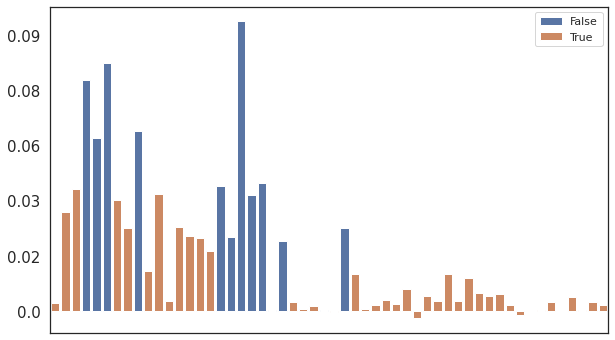

In [58]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set(style='white')
fig = sns.barplot(data = vcf_robust_average, x= 'model', y = 'diff',order = order,hue = 'shift augmentation',dodge = False)
fig.set(xlabel='', ylabel='')
fig.set_yticklabels(fig.get_yticks().astype('U4'), size = 15)
fig.set(xticklabels=[]);
plt.legend(loc='upper right');

In [59]:
len(vcf_robust_average[vcf_robust_average['shift augmentation']==True])

41

## Compare Profile vs Binary in CAGI&Performance

In [60]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import h5py
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy

In [61]:
#binary_models
rb_bi = '/home/amber/QuantPred/paper_runs/binary/mod_binary/run-20211019_161849-9ygdmjss/files/best_model.h5'
basset_bi = '/home/amber/QuantPred/paper_runs/binary/basset/run-20210825_040148-nieq47kf/files/best_model.h5'
#coverage models
rb_cov = '/home/amber/QuantPred/paper_runs/coverage/rb_global_cov.h5'
basset_cov = '/home/amber/QuantPred/paper_runs/coverage/Basset_cov.h5'
#profile models
bpnet_base = '/home/amber/QuantPred/paper_runs/bpnet/augmentation_48/run-20211006_190817-456uzbu4/files/best_model.h5'
basenji_128 = '/home/amber/QuantPred/paper_runs/basenji/augmentation_basenji//run-20210924_160405-psjsjf84/files/best_model.h5'
basenji_2k = '/home/amber/QuantPred/paper_runs/basenji/binloss_basenji/run-20210920_085441-14shgpx1/files/best_model.h5'
rb_32 ='/home/amber/QuantPred/paper_runs/new_models/32_res/run-20211023_095136-to28llil/files/best_model.h5'
rb_base = '/home/amber/QuantPred/paper_runs/new_models/base_res/run-20211022_141032-m1cjyb3z/files/best_model.h5'
#model_fn_dict
model_fn_dict={rb_bi:'rb_bi',basset_bi:'basset_bi',rb_cov:'rb_cov',basset_cov:'basset_cov',bpnet_base:'bpnet_base',
             basenji_128:'basenji_128',basenji_2k:'basenji_2k',rb_32:'rb_32',rb_base:'rb_base'}

In [62]:
comp_df = pd.read_csv('/home/amber/QuantPred/datasets/binary/performance.csv',index_col = 0)
cagi_df = pd.read_csv(cagi_meta,
                      index_col=0).reset_index()

In [63]:
run_dir_list = []
for model_name in comp_df['model']:
    run_dir = globals()[model_name]
    if 'coverage' in run_dir:
        run_dir = run_dir.split('/')[-1]
        run_dir = run_dir.split('.')[0]
    elif 'binary' in run_dir:
        run_dir = run_dir.split('/')[-4]
    else:
        run_dir = run_dir.split('/')[-3]
    run_dir = run_dir.split('-')[-1]
    run_dir_list.append(run_dir)
comp_df['run_dir'] = run_dir_list

In [64]:
comparison_cagi = comp_df.merge(all_vcf_df, left_on='run_dir', right_on='model')

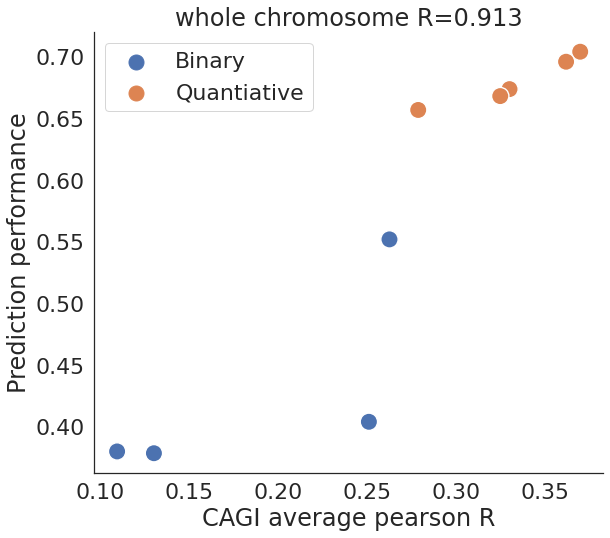

In [73]:
sns.set(font_scale = 2,style='white')
fig = plt.figure(figsize = (9,8))



ax = sns.scatterplot(data=comparison_cagi,x ='Average' ,y = 'chr pearson r',hue = 'model type',
                    s = 300)
ax.set_xlabel('CAGI average pearson R')
ax.set_ylabel('Prediction performance')
ax.set_title('whole chromosome R=' + "%.3f"%scipy.stats.pearsonr(comparison_cagi['chr pearson r'],comparison_cagi['Average'])[0])
# legend = ax.legend()
# legend.remove()
ax.legend(loc = 'upper left',markerscale = 2.5)
sns.despine()
plt.tight_layout()
plt.show()